In [1]:
import sys
sys.path.append("/home/huaqingj/MyResearch/TVDN-AD")

In [2]:
from scipy.fft import fft, fftfreq
import numpy as np
from pyTVDN import TVDNDetect
from pathlib import Path
from scipy.io import loadmat, savemat
from easydict import EasyDict as edict
from collections import defaultdict as ddict
import matplotlib
import matplotlib.pyplot as plt
import os
from scipy import signal
from tqdm import tqdm
import pickle
import mat73
import scipy
%matplotlib inline

### Load data

In [3]:
os.chdir("/home/huaqingj/MyResearch/TVDN-AD")
resDir = Path("./results")
dataDir = Path("./data")

In [4]:
# ecpts
fil = list(resDir.glob("AD_*_ecpts.pkl"))[0]
with open(fil, "rb") as f:
    ecptssAD = pickle.load(f)
fil = list(resDir.glob("Ctrl_*_ecpts.pkl"))[0]
with open(fil, "rb") as f:
    ecptssCtrl = pickle.load(f)

In [5]:
ecptssADFull = [np.concatenate([[0], ecpts, [7200]])*5 for ecpts in ecptssAD]
ecptssCtrlFull = [np.concatenate([[0], ecpts, [7200]])*5 for ecpts in ecptssCtrl]

In [6]:
filAD = "87ADs_before_filter1000.mat" # 0-86
filCtrl = "70Ctrls_before_filter1000.mat" #0-69
filADadd = "DK_timecourse.mat" # 87
filCtrladd = "timecourse_ucsfCONT_group.mat" # 70-91

In [7]:
ADdatasets = loadmat(dataDir/filAD)["dk10"]
Ctrldatasets = loadmat(dataDir/filCtrl)["dk10"]
ADdatAdd = loadmat(dataDir/filADadd)["DK_timecourse"]
CtrldatAdd = mat73.loadmat(dataDir/filCtrladd)["dk10"]

In [107]:
from scipy.io import savemat
saveFil = mat73.loadmat(dataDir/filCtrladd)
savemat("timecourse_ucsfCONT_group1.mat", saveFil)

In [8]:
ADdatAdd = ADdatAdd.reshape(1, 68, 36000)
DatAll = np.concatenate([ADdatasets, ADdatAdd, Ctrldatasets, CtrldatAdd])

### FFT 

In [9]:
from scipy.interpolate import interp1d

In [10]:
N = DatAll.shape[-1] # num of pts in total 
fs = 600 # sampling freq
bandsNames = ["Delta-Theta", "Alpha", "Beta", "All Bands"]
bands = [[2, 7], [8, 12], [13, 35], [2, 35]]
freqs = np.arange(N)*fs/N # the freq for each power
winsize = fs * 5
winstep = fs * 3
#cFreqs = np.arange(winsize)*fs/winsize

In [11]:
def FFTinterp(curDat, preFreqs):
    cN = curDat.shape[-1]
    cFreqs = np.arange(cN)*fs/cN
    fftRes = fft(curDat)
    powers = np.abs(fftRes/winsize)**2 + 1e-30
    powers = 10 * np.log10(powers) # to dB
    interF = interp1d(cFreqs, powers)
    retPowers = interF(preFreqs)
    return retPowers

In [12]:
def TVDNFFTinterp(curDat, ecpts, preFreqs):
    powerss = []
    for ix in range(len(ecpts)-1):
        curLow, curUp = int(ecpts[ix]), int(ecpts[ix+1])
        redCurDat = curDat[:, curLow:curUp]
        retPowers = FFTinterp(redCurDat, preFreqs)
        powerss.append(retPowers)
    mPowers = np.mean(np.array(powerss), axis=0)
    return mPowers, preFreqs

In [13]:
def winFFTinterp(curDat, winsize, winstep, preFreqs):
    curLow = 0
    curUp = curLow + winsize
    powerss = []
    while (curUp<(N-1)):
        redCurDat = curDat[:, curLow:curUp]
        retPowers = FFTinterp(redCurDat, preFreqs)
        powerss.append(retPowers)
        curLow, curUp = curLow+winstep, curUp+winstep
    mPowers = np.mean(np.array(powerss), axis=0)
    return mPowers, preFreqs

In [14]:
def winFFT(curDat, winsize, winstep):
    curLow = 0
    curUp = curLow + winsize
    cFreqs = np.arange(winsize)*fs/winsize
    powerss = []
    while (curUp<(N-1)):
        redCurDat = curDat[:, curLow:curUp]
        fftRes = fft(redCurDat)
        powers = np.abs(fftRes/winsize)**2 + 1e-30
        powers = 10 * np.log10(powers) # to dB
        powerss.append(powers)
        curLow, curUp = curLow+winstep, curUp+winstep
    mPowers = np.mean(np.array(powerss), axis=0)
    return mPowers, cFreqs

In [73]:
# TVDN FFT (interpolation)
preFreqs = np.linspace(0, 100, 1000)
resPower = ddict(list)
for ix in tqdm(range(DatAll.shape[0])):
    curDat = DatAll[ix, :, :]
    if ix >= len(ecptssADFull):
        ecpts = ecptssCtrlFull[ix-len(ecptssADFull)]
    else:
        ecpts = ecptssADFull[ix]
    powers, cFreqs = TVDNFFTinterp(curDat, ecpts, preFreqs)
    kpIdxFn = lambda x: np.bitwise_and(cFreqs >=x[0], cFreqs<=x[1])
    for band, bandName in zip(bands, bandsNames):
        curPower = powers[:, kpIdxFn(band)]
        resPower[bandName].append(curPower)

100%|██████████| 180/180 [00:18<00:00,  9.55it/s]


In [89]:
# slide-window FFT
resPower = ddict(list)
for ix in tqdm(range(DatAll.shape[0])):
    curDat = DatAll[ix, :, :]
    powers, cFreqs = winFFT(curDat, winsize, winstep)
    kpIdxFn = lambda x: np.bitwise_and(cFreqs >=x[0], cFreqs<=x[1])
    for band, bandName in zip(bands, bandsNames):
        curPower = powers[:, kpIdxFn(band)]
        resPower[bandName].append(curPower)

100%|██████████| 180/180 [00:18<00:00,  9.88it/s]


### Analysis

In [90]:
import pandas as pd
import seaborn as sns

In [91]:
allDataOrd = pd.read_csv("./OtherFils/AllDataBaselineOrdered.csv")
KpIt = np.array(allDataOrd["KeepIt"])
Grp = np.array(allDataOrd["Grp"])

In [92]:
meanPowerAll = ddict(list)
kpIdxFnDF = lambda x: np.bitwise_and(KpIt==1, Grp==x)
for bandName in bandsNames:
    meanPower = np.array([np.mean(i, axis=-1) for i in resPower[bandName]])
    
    curKpIdx = kpIdxFnDF("AD")
    meanPowerAll["Value"] = meanPowerAll["Value"] + list(meanPower[curKpIdx, :].reshape(-1))
    meanPowerAll["Grp"] = meanPowerAll["Grp"] + ["AD"] * (curKpIdx.sum()*68)
    meanPowerAll["Band"] = meanPowerAll["Band"] + [bandName] *(curKpIdx.sum()*68)
    
    
    curKpIdx = kpIdxFnDF("Ctrl")
    meanPowerAll["Value"] = meanPowerAll["Value"] + list(meanPower[curKpIdx, :].reshape(-1))
    meanPowerAll["Grp"] = meanPowerAll["Grp"] + ["Ctrl"] * (curKpIdx.sum()*68)
    meanPowerAll["Band"] = meanPowerAll["Band"] + [bandName] * (curKpIdx.sum()*68)

In [93]:
meanPowerDF = pd.DataFrame(meanPowerAll)

<AxesSubplot:xlabel='Band', ylabel='Value'>

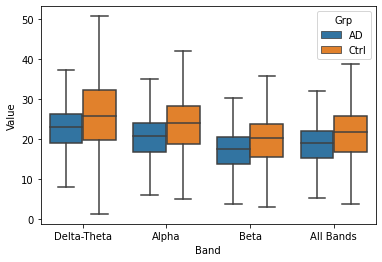

In [94]:
sns.boxplot(y="Value", x="Band", hue="Grp", data=meanPowerDF, showfliers = False, orient="v")

In [95]:
ADm = np.mean(np.array(resPower["All Bands"])[kpIdxFnDF("AD"), :, :].reshape(88*68, -1), axis=0)
ADCI = np.quantile(np.array(resPower["All Bands"])[kpIdxFnDF("AD"), :, :].reshape(88*68, -1), [0.025, 0.975], axis=0)
Ctrlm = np.mean(np.array(resPower["All Bands"])[kpIdxFnDF("Ctrl"), :, :].reshape(88*68, -1), axis=0)
CtrlCI = np.quantile(np.array(resPower["All Bands"])[kpIdxFnDF("Ctrl"), :, :].reshape(88*68, -1), [0.025, 0.975], axis=0)

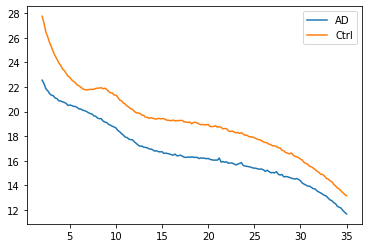

In [97]:
cFreqs = np.arange(winsize)*fs/winsize
#cFreqs = preFreqs
kpIdxFn = lambda x: np.bitwise_and(cFreqs >=x[0], cFreqs<=x[1])
plt.plot(cFreqs[kpIdxFn([2, 35])], ADm, "-", label="AD")
plt.plot(cFreqs[kpIdxFn([2, 35])], Ctrlm, "-", label="Ctrl")
plt.legend()

In [98]:
curBand = "Alpha"
curADs = meanPowerDF[(meanPowerDF["Grp"] == "AD") & (meanPowerDF["Band"] == curBand)]["Value"]
curCtrls = meanPowerDF[(meanPowerDF["Grp"] == "Ctrl") & (meanPowerDF["Band"] == curBand)]["Value"]
pv = scipy.stats.ttest_ind(curADs, curCtrls, equal_var=False)
print(f"The band is {curBand}, and the t-test has a pvalue of {pv.pvalue:.3E}.")

The band is Alpha, and the t-test has a pvalue of 1.286E-29.


In [99]:
curBand = "Beta"
curADs = meanPowerDF[(meanPowerDF["Grp"] == "AD") & (meanPowerDF["Band"] == curBand)]["Value"]
curCtrls = meanPowerDF[(meanPowerDF["Grp"] == "Ctrl") & (meanPowerDF["Band"] == curBand)]["Value"]
pv = scipy.stats.ttest_ind(curADs, curCtrls, equal_var=False)
print(f"The band is {curBand}, and the t-test has a pvalue of {pv.pvalue:.3E}.")

The band is Beta, and the t-test has a pvalue of 5.136E-28.


In [100]:
curBand = "Alpha"
allmPs = np.array([np.mean(i, axis=-1).max() for i in resPower[curBand]])
curADs = allmPs[kpIdxFnDF("AD")]
curCtrls = allmPs[kpIdxFnDF("Ctrl")]
pv = scipy.stats.ttest_ind(curADs, curCtrls, equal_var=False)
print(f"The band is {curBand}, and the t-test has a pvalue of {pv.pvalue:.3E}.")

The band is Alpha, and the t-test has a pvalue of 5.567E-04.


In [101]:
curBand = "Beta"
allmPs = np.array([np.mean(i, axis=-1).max() for i in resPower[curBand]])
curADs = allmPs[kpIdxFnDF("AD")]
curCtrls = allmPs[kpIdxFnDF("Ctrl")]
pv = scipy.stats.ttest_ind(curADs, curCtrls, equal_var=False)
print(f"The band is {curBand}, and the t-test has a pvalue of {pv.pvalue:.3E}.")

The band is Beta, and the t-test has a pvalue of 2.182E-03.


### Save results

In [102]:
import pickle

In [104]:
curBand = "Alpha"
allmPs = np.array([np.mean(i, axis=-1).max() for i in resPower[curBand]])
curADs = allmPs[Grp=="AD"]
curCtrls = allmPs[Grp=="Ctrl"]
with open(f"slideWin_Power_{curBand}.pkl", "wb") as f:
#with open(f"TVDN_Power_{curBand}.pkl", "wb") as f:
    pickle.dump([curADs, curCtrls], f)

### Results with `pmtm` 

In [129]:
PSDp = list(resDir.glob("87*PSD.mat"))[0]
AD1 = loadmat(PSDp)["fmegall"]

PSDp = list(resDir.glob("DK*PSD.mat"))[0]
AD2 = loadmat(PSDp)['FMEGdata']

PSDp = list(resDir.glob("70*PSD.mat"))[0]
Ctrl1 = loadmat(PSDp)["fmegall"]

PSDp = list(resDir.glob("timecourse*PSD.mat"))[0]
Ctrl2 = loadmat(PSDp)["fmegall"]

In [257]:
KpIt1 = np.concatenate([np.ones(87), [0], np.ones(70), np.zeros(22)])
kpIdxFnDF1 = lambda x: np.bitwise_and(KpIt1==1, Grp==x)

In [258]:
PSDsall = np.concatenate([AD1, AD2.reshape(1, 68, 40), Ctrl1, Ctrl2])

In [259]:
ADPSD = 10*np.log10(PSDsall[kpIdxFnDF1("AD"), :, :].reshape(-1, 40))
CtrlPSD = 10*np.log10(PSDsall[kpIdxFnDF1("Ctrl"), :, :].reshape(-1, 40))
ADPSD = PSDsall[kpIdxFnDF1("AD"), :, :].reshape(-1, 40)
CtrlPSD = PSDsall[kpIdxFnDF1("Ctrl"), :, :].reshape(-1, 40)

In [260]:
ADm = ADPSD.mean(axis=0)
ADsd = ADPSD.std(axis=0)
ADdlt = 1.96*ADsd/np.sqrt(ADPSD.shape[0])
Ctrlm = CtrlPSD.mean(axis=0)
Ctrlsd = CtrlPSD.std(axis=0)
Ctrldlt = 1.96*Ctrlsd/np.sqrt(CtrlPSD.shape[0])

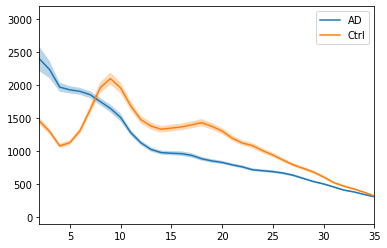

In [261]:
Freqs = np.arange(1, 41)
plt.plot(Freqs, ADm, "-", label="AD")
plt.fill_between(Freqs, ADm-ADdlt, ADm+ADdlt, alpha=0.3)
plt.plot(Freqs, Ctrlm, "-", label="Ctrl")
plt.fill_between(Freqs, Ctrlm-Ctrldlt, Ctrlm+Ctrldlt, alpha=0.3)
plt.xlim([2, 35])
#plt.ylim([20, 29])
plt.legend()

In [268]:
curBand = [2, 7]
#allPSD = (PSDsall[:, :, np.bitwise_and(Freqs>=curBand[0], Freqs<=curBand[1])]).mean(axis=-1).mean(axis=-1)
allPSD = (10*np.log10(PSDsall[:, :, np.bitwise_and(Freqs>=curBand[0], Freqs<=curBand[1])])).mean(axis=1).mean(axis=-1)
pv = scipy.stats.ttest_ind(allPSD[kpIdxFnDF1("AD")], allPSD[kpIdxFnDF1("Ctrl")])
print(pv.pvalue)

0.08137927632395965


In [267]:
PSDsall[:, :, np.bitwise_and(Freqs>=curBand[0], Freqs<=curBand[1])].shape

(180, 68, 6)

In [219]:
curBand = [13, 35]
allPSD = (10*np.log10(PSDsall[:, :, np.bitwise_and(Freqs>=curBand[0], Freqs<=curBand[1])])).mean(axis=-1).mean(axis=-1)
pv = scipy.stats.ttest_ind(allPSD[kpIdxFnDF1("AD")], allPSD[kpIdxFnDF1("Ctrl")])
print(pv.pvalue)
#with open(f"pmtm_Power_Beta.pkl", "wb") as f:
#    pickle.dump([allPSD[Grp=="AD"], allPSD[Grp=="Ctrl"]], f)

0.7985667863906852


0.09305911456198955


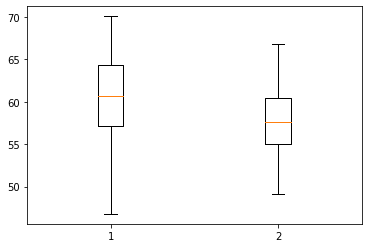

In [245]:
curBand = [2, 4]
allPSD = (20*np.log10(PSDsall[:, :, np.bitwise_and(Freqs>=curBand[0], Freqs<=curBand[1])])).mean(axis=-1).mean(axis=-1)
pv = scipy.stats.ttest_ind(allPSD[kpIdxFnDF1("AD")], allPSD[kpIdxFnDF1("Ctrl")], equal_var=False)
print(pv.pvalue)
#with open(f"pmtm_Power_delthe.pkl", "wb") as f:
#    pickle.dump([allPSD[Grp=="AD"], allPSD[Grp=="Ctrl"]], f)
_ = plt.boxplot([allPSD[kpIdxFnDF1("AD")], allPSD[kpIdxFnDF1("Ctrl")]], showfliers=False)

In [196]:
curBand = [8, 12]
allPSD = (10*np.log10(PSDsall[:, :, np.bitwise_and(Freqs>=curBand[0], Freqs<=curBand[1])])).mean(axis=-1)
pv = scipy.stats.ttest_ind(allPSD[kpIdxFnDF("AD"), :].reshape(-1), allPSD[kpIdxFnDF("Ctrl"), :].reshape(-1))
pv.pvalue

0.8816133867735987

In [195]:
curBand = [13, 35]
allPSD = (10*np.log10(PSDsall[:, :, np.bitwise_and(Freqs>=curBand[0], Freqs<=curBand[1])])).mean(axis=-1)
pv = scipy.stats.ttest_ind(allPSD[kpIdxFnDF("AD"), :].reshape(-1), allPSD[kpIdxFnDF("Ctrl"), :].reshape(-1))
pv.pvalue

1.0687129863263336e-05

In [231]:
curBand = [2, 7]
allPSD = (10*np.log10(PSDsall[:, :, np.bitwise_and(Freqs>=curBand[0], Freqs<=curBand[1])])).mean(axis=-1)
pv = scipy.stats.ttest_ind(allPSD[kpIdxFnDF1("AD"), :].reshape(-1), allPSD[kpIdxFnDF1("Ctrl"), :].reshape(-1))
pv.pvalue

1.446294901958764e-39

Ttest_indResult(statistic=0.020339355382433793, pvalue=0.983795965909833)